In [4]:
#This part 4 of the 5 parts tutorial to show you how to Machine learning using classical machine learning algorithms! 
#The task is to classify talks and abstracts into their years (or year spans). 
# For example a talk titled "Systems security" belongs to year 1999 or to the 1990s span.
#We go a step forward by showing you how to create noun-clouds and verb-clouds using SpaCy.
#Our data-set is a list of talks and abstracts from the CCC conference https://gitlab.com/maxigas/cccongresstalks/

import warnings
warnings.filterwarnings("ignore")


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns
import mglearn
from sklearn.feature_extraction.text import CountVectorizer


In [5]:
# Input data files are available in the "../csvs/" directory.

directory = "csvs/"
combinedFile = "csvs/combined_csv.csv"

combinedSpanFile = "csvs/combined_span_csv.csv"

# delete csv combined-spans if it exists so it doesn't duplicate its contents (I later explain what this file is)
if os.path.exists(combinedSpanFile):
    os.remove(combinedSpanFile)
    
# delete csv combined if it exists so it doesn't duplicate its contents (I later explain what this file is)
if os.path.exists(combinedFile):
    os.remove(combinedFile)

#The following loops through the CSV files and shows how many talks (rows) are there in each year.
for filename in os.listdir(directory):
    if filename.endswith(".csv"): 
        print(filename)
        df1 = pd.read_csv((directory+'/'+filename), delimiter='|', header=0, error_bad_lines=False)
        print('Number of titles: {:,}\n'.format(df1.shape[0]))
        continue

1984.csv
Number of titles: 11

1985.csv
Number of titles: 3

1986.csv
Number of titles: 15

1987.csv
Number of titles: 28

1989.csv
Number of titles: 11

1990.csv
Number of titles: 17

1991.csv
Number of titles: 26

1992.csv
Number of titles: 14

1993.csv
Number of titles: 26

1994.csv
Number of titles: 23

1995.csv
Number of titles: 42

1996.csv
Number of titles: 42

1997.csv
Number of titles: 43

1998.csv
Number of titles: 49

1999.csv
Number of titles: 63

2000.csv
Number of titles: 51

2001.csv
Number of titles: 88

2002.csv
Number of titles: 97

2003.csv
Number of titles: 91

2004.csv
Number of titles: 202

2005.csv
Number of titles: 144

2006.csv
Number of titles: 155

2007.csv
Number of titles: 102

2008.csv
Number of titles: 93

2009.csv
Number of titles: 89

2010.csv
Number of titles: 95

2011.csv
Number of titles: 98

2012.csv
Number of titles: 108

2013.csv
Number of titles: 214

2014.csv
Number of titles: 138

2015.csv
Number of titles: 151

2016.csv
Number of titles: 149



In [6]:
#The following loops through all the CSVs (per year) in the CSV file and creates a combined file with data from all csvs into one.
import glob
import pandas as pd
from os import listdir
from os.path import isfile, join

# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedFile):
    os.remove(combinedFile)
    
extension = 'csv'
#notice that the code changes the delimiter from "|" to "," which is the norm.
all_filenames = [f for f in listdir(directory) if isfile(join(directory, f))]
#combine all files in the list
combined_csv = pd.concat([pd.read_csv((directory+'/'+f), delimiter='|', error_bad_lines=False).replace({',': ' '}, regex=False) for f in all_filenames ])
#export to csv
combined_csv.to_csv(combinedFile, index=False,encoding='utf-8-sig')

#read the newly created combined file and show a sample of 10 rows (notice teh year column)
df_years = pd.read_csv(combinedFile, delimiter=',', header=0, error_bad_lines=False)
print('Number of titles: {:,}\n'.format(df_years.shape[0]))
df_years.sample(10)

Number of titles: 2,973



,year,congress,title,abstract,link,tags
55,1987,4C3,"Abbau, aufräumen...",NaN,NaN,NaN
708,2003,20C3,LFS (Linux from Scratch) --- Jule Riede (Haeck...,Hands-on Workshop mit kurzem einfuehrendem Vor...,http://www.ccc.de/congress/2003/fahrplan/event...,NaN
446,2000,17C3,MP3-Psychoakustik,"Ich plane Erklrungen zum Gehör (Bau, Funktion,...",https://events.ccc.de/congress/2000/fahrplan/e...,NaN
1683,2011,28C3,"Not your Grandfathers moon landing: Hell yeah,...",We got a new rover and it's much more awesome ...,https://events.ccc.de/congress/2011/Fahrplan/s...,NaN
2402,2016,33C3,On the securityz and Privacy of Modern Single ...,<p>Many web sites allow users to log in with t...,https://events.ccc.de/congress/2016/Fahrplan/s...,NaN
530,2001,18C3,TCP-Hijacking-Workshop,Hier werden verschiedene Angriffsvarianten erö...,https://events.ccc.de/congress/2001/fahrplan/e...,NaN
739,2003,20C3,Wettbewerb „Homöomorphe Endmontage“ (Workshop)...,Jeder Teilnehmer bekommt ein Exemplar des glei...,http://www.ccc.de/congress/2003/fahrplan/event...,NaN
2803,2018,35C3,Let's reverse engineer the Universe: Up and to...,There is four times more dark matter and over ...,https://events.ccc.de/congress/2018/Fahrplan/s...,NaN
2813,2019,36C3,Opening Ceremony (de): Security Track Keynote,Welcome!,https://events.ccc.de/congress/2019/Fahrplan/s...,NaN
824,2004,21C3,Intellektuelle Selbstverteidigung,Intellektuelle Selbstverteidigung Da uns niema...,http://www.ccc.de/congress/2004/fahrplan/event...,NaN


In [7]:
#what the following code does is it plays with the years to make them look like a span of years.
#The reason I do that to show you later that classifying text (titles or abstracts) into years will yield low accuracy results 
#   as there are 35 years of talks
# What I will do is group the years into a span of 1980s, 1990s, 2000s and 2010s(this includes years from 2010 and later)
import re

combinedSpanFile = "csvs/combined_span_csv.csv"

# delete csv combined if it exists so it doesn't duplicate its contents
if os.path.exists(combinedSpanFile):
    os.remove(combinedSpanFile)

# here is a list of replace statements to convert years into year spans (i'm sure there is a better way to do this but this suffice :) 
# we save the updated year combined file to a new file called "combined_span_csv.csv".
with open(combinedFile, "rt", encoding="utf8") as fin:
    with open(combinedSpanFile, "wt", encoding="utf8") as fout:
        for line in fin:
            newString = re.sub("201\d{1}", "2010", line)
            newString = re.sub("200\d{1}", "2000", newString)
            newString = re.sub("198\d{1}", "1980", newString)
            newString = re.sub("199\d{1}", "1990", newString)
            fout.write(newString)

In [8]:
#here I print a sample of 10 rows from the combined_span_csv.csv file.
combinedSpanFile = "csvs/combined_span_csv.csv"

df_span = pd.read_csv(combinedSpanFile, delimiter=',', header=0, error_bad_lines=False)
print('Number of titles: {:,}\n'.format(df_span.shape[0]))
df_span.sample(10)


Number of titles: 2,973



,year,congress,title,abstract,link,tags
2445,2010,33C3,JODI - Apache is functioning normally : An exp...,"Joan Heemskerk and Dirk Paesmans, collectively...",https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1738,2010,29C3,Cyberpeace statt Cyberwar,Wir sind Zeugen eines seit einigen Jahren stat...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1923,2010,30C3,Deutschlandfunk - Das 30C3-Interview mit ...: ...,NaN,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1576,2010,27C3,Data Recovery Techniques: Fun with Hard Drives,Data recovery has always been an area of myths...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1699,2010,28C3,Introducing Osmo-GMR: Building a sniffer for t...,The latest member of the Osmocom-family projec...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
191,1990,12C3,Wau HollandDumpfhoheit in Netzstrümpfen,NaN,https://events.ccc.de/congress/1990/fahrplan.htm,NaN
1863,2010,30C3,The GNU Name System: Embedded securityz Using ...,"DNS, DNSSEC and the X.509 CA system leak priva...",https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1580,2010,27C3,Console hackz 2010: PS3 Epic Fail,"Over 70 million Wiis, over 40 million Xbox 360...",https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
2428,2010,33C3,"On Smart Cities, Smart Energy, And Dumb securityz",Smart City is an abstract concept everyone tal...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN
1845,2010,30C3,Der Kampf um Netzneutralität: OMG - my Smart T...,Seit Jahren nur in Fachzirkeln diskutiert gab ...,https://events.ccc.de/congress/2010/Fahrplan/s...,NaN


Number of titles: 2,973

<class 'dict'>
X_train 519     Ohne auf Details wie die securityz von Algorit...
1539    There's been a fair bit written and presented ...
932     Wettkampf HandĂśffnung (Finale) 8. Deutsche Me...
1064    A discussion of the Intellectual Contributions...
1371    securityz audits of PHP applications are usual...
811     hackztivity Clifford Wolf Um den Menschen wied...
719     Dieser Vortrag beschäftigt sich mit dem Einsat...
1303    Der lange Schwanz der Dating-Communities sowie...
2935    Three and a half years after Europe enshrined ...
2923    IT-Sicherheitsgesetz 2.0, Staatstrojaner für d...
1770    In 1791, the political reformer Jeremy Bentham...
769     Closing Event So long and thanks for all the f...
2897    Ruckus Networks is a company selling wired and...
1493    Auch dieses Jahr werden wir Euch wieder aus de...
2694    This lecture tells the story of Internet infra...
1468    Stories of journalists who while doing their w...
105            "Workshop

Training/Testing Accuracy 	 SVM 	 0.9978165938864629 	 0.7137404580152672
X_train 519     Ohne auf Details wie die securityz von Algorit...
1539    There's been a fair bit written and presented ...
932     Wettkampf HandĂśffnung (Finale) 8. Deutsche Me...
1064    A discussion of the Intellectual Contributions...
1371    securityz audits of PHP applications are usual...
811     hackztivity Clifford Wolf Um den Menschen wied...
719     Dieser Vortrag beschäftigt sich mit dem Einsat...
1303    Der lange Schwanz der Dating-Communities sowie...
2935    Three and a half years after Europe enshrined ...
2923    IT-Sicherheitsgesetz 2.0, Staatstrojaner für d...
1770    In 1791, the political reformer Jeremy Bentham...
769     Closing Event So long and thanks for all the f...
2897    Ruckus Networks is a company selling wired and...
1493    Auch dieses Jahr werden wir Euch wieder aus de...
2694    This lecture tells the story of Internet infra...
1468    Stories of journalists who while doing t

Training/Testing Accuracy 	 NB 	 0.732532751091703 	 0.6335877862595419


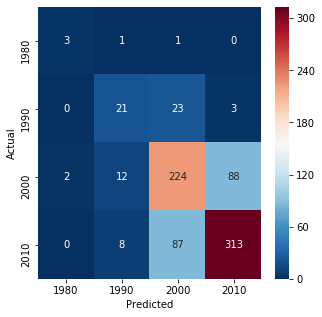

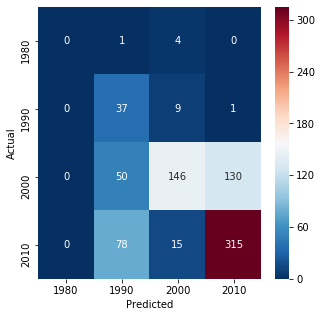

In [10]:
#This line changes the way the machine learning works
#keepnig df as df_span will classify text into 4 classes 1980s,1990s,2000s,2010s
#changing it to df_years will classify text into 35 classes which will of course result in lower scores.
df = df_span

#print(os.getcwd())
plots = "plots"

import pandas as pd
import matplotlib.pyplot as plt

#thsi prints how many samples are tehre in the combined (or span) file.
df.head()
print('Number of titles: {:,}\n'.format(df.shape[0]))

#we are only intersted in classifying the abstracts as they have more text than the titles. To change that replace abstract with title all over.
from io import StringIO
col = ['year', 'abstract'] #those are the two columns we are interested in bascially (label: Year, Text: abstract)
df = df[col]
#make sure we have no null abstracts to avoid any errors
df = df[pd.notnull(df['abstract'])]
df.columns = ['year', 'abstract']

#create teh categories (labels) from the year column
df['category_id'] = df['year'].factorize()[0]
category_id_df = df[['year', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
print(type(category_to_id))
id_to_category = dict(category_id_df[['category_id', 'year']].values)
df.head()

#I'm only showing you the Support Vector Machines (SVM) and Naive Bayes (NB) classifiers, 
#The implementation for Logistic Regression (LR) is in there you just need to add "LR" to the array below.
modelsArray = ["SVM","NB"]
for w in range(len(modelsArray)):
    model_type = modelsArray[w]
    import numpy as np
    from sklearn.model_selection import train_test_split
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer 
    from sklearn.feature_extraction.text import TfidfTransformer
    from sklearn.naive_bayes import MultinomialNB
    from nltk import pos_tag
    from nltk.corpus import stopwords
    from nltk.stem import WordNetLemmatizer
    from sklearn import svm
    from sklearn.linear_model import LogisticRegression

    #prepare the training and testing dataset
    #This randomly splits our data into training and testing, here we choose to go with 0.30 (30%) for testing and the rest for training
    #X in our case is the text (abstract), Y is the labels (years)
    X_train, X_test, y_train, y_test = train_test_split(df['abstract'], df['year'],random_state = 1, test_size=0.30)
    
    from nltk.corpus import stopwords
        
    #we use a bag of words approach, here we go with 1 ngram, if you want bigrams (2,2), unigrams and bigrams (1,2)...etc
    count_vect = CountVectorizer(analyzer='word', ngram_range=(1, 1))#ngram size, default 1,1, default word ngrams
    
    #you can use a tf, idf vectorizer which should do better than word frequency, I also show you how to remove stop words.
    #count_vect = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words = stopwords.words("english"), sublinear_tf=True)#ngram size, default 1,1, default word ngrams
    
    count_vect.fit(X_train)    
    #transforming data to be ready for analysis and machine learning
    #handling missing data, remove string formatting, convert categorical data to numerical ....etc
    X_train_tfidf = count_vect.transform(X_train)
    X_train_tfidf = count_vect.fit_transform(X_train)
    X_test_tfidf = count_vect.transform(X_test)
    
    #algorithms setup, you can change the C value for SVM
    if model_type=="SVM":
        clf = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
    if model_type=="NB":
        clf = MultinomialNB()
    if model_type=="LR":
        clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='multinomial', max_iter=4000)

    #train the model
    train_model=clf.fit(X_train_tfidf, y_train)
    #predicting years for testing data
    test_accuracy=train_model.predict(X_test_tfidf)
    #print training and testnig accuracy
    print("Training/Testing Accuracy" , '\t' , model_type , '\t' , train_model.score(X_train_tfidf, y_train) , '\t' , train_model.score(X_test_tfidf, y_test))

    #plot confusion matrices
    import seaborn as sns
    from sklearn.metrics import confusion_matrix
    conf_mat = confusion_matrix(y_test, test_accuracy)
    fig, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(conf_mat, annot=True, fmt='d',cmap="RdBu_r",
                xticklabels=category_id_df.year.values, yticklabels=category_id_df.year.values)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    #plt.show(block=False)
    pltFileName = plots+'/'+'combined'+'_'+model_type+'.pdf';
    plt.savefig(pltFileName)